In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd

In [0]:
# Define the dataset class for a custom dataset
class CustomDataset(Dataset):
    
    def __init__(self, data_frame, transform=None):
        self.data = data_frame
        self.transform = transform
#         
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        obs = self.data.iloc[index, 0 : 2].values
        label = self.data.iloc[index, 2]
        
        if self.transform is not None:
            obs = self.transform(obs)
            
        return obs, label

(-20, 20)

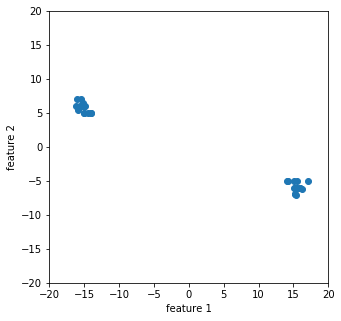

In [0]:
# Create the toy data
data_ = pd.DataFrame({'X1' : [-15, -15 ,-15.2, -15.4, -15.52, -14.89, -14.5, -16.222, 16, 15.1, 15.2, 15.4, 15.52, 15.155, 15.02, 15.222,
                              -15, -15.66 ,-15.92, -15.12, -15, -14, -14, -16, 16, 14.1, 14.2, 15.4, 15.52, 15.155, 17.02, 16.222],
                   'X2' : [5, 5, 6.5, 6, 7.021, 6.03, 5.05, 6.016, -6, -5, -6.01, -7.011, -5.021, -7, -6.05, -6.016,
                           6, 6, 5.5, 6, 6.021, 5.03, 5.05, 7.016, -6, -5, -5.01, -6.011, -6.021, -7, -5.05, -6.216], 
                   'label' : [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
                              1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]})
# Plot the toy data
plt.figure(figsize = (5, 5))
plt.scatter(data_['X1'], data_['X2'])
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [0]:
train_dataset = CustomDataset(data_, transform = None)

In [0]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()
    self.fc1 = nn.Linear(2, 1)
    nn.init.xavier_normal_(self.fc1.weight)
    self.fc2 = nn.Linear(2, 1)
    nn.init.xavier_normal_(self.fc2.weight)
    # self.fc3 = nn.Linear(2, 1)
    # nn.init.xavier_normal_(self.fc3.weight)

  def forward(self, x):
    x = x.view(-1, 2)
    x1 = torch.sigmoid( self.fc1(x) )  
    x2 = torch.sigmoid( self.fc2(x) )  
    # x3 = torch.sigmoid( self.fc3(x) )  
    
    return x1, x2#, x3
  
model = linear_model()  

In [0]:
# #Script for generating fancy inner product matrix:

# sigma = 0.1 #HIGHER VALUES OF SIGMA SEEM TO PERFORM BETTER
# M = torch.zeros([2, 2])

# M_tensor = M.view(1,1,28,28)

# for i_1 in range(28):
#     for i_2 in range(28):
#         for j_1 in range(28):
#             for j_2 in range(28):
#                 M_tensor[i_1,i_2,j_1,j_2] = np.exp( -((i_1 - j_1)**2 + (i_2 - j_2)**2) / (2 * (sigma)**2) )

# M = M_tensor.view([28*28,28*28])

In [0]:
# Define loss function and optimizer
import torch.optim as optim

loss_function = nn.BCELoss(reduction = 'mean') # sums all outputs and divides by total data points

optimizer = optim.Adam(model.parameters(), lr = 0.1)

class custom_loss(torch.nn.Module):

  def __init__(self):
    super(custom_loss,self).__init__()

  def forward(self, mat1, mat2):
  # Absolute dot product of weights
    l = (torch.mm(mat1, mat2.t()))**2

  # Fancy dot product if weights
#     l = (torch.mm(mat1, torch.mm(M, mat2.t())))**2
    return l

class regularizer(torch.nn.Module):

  def __init__(self):
    super(regularizer,self).__init__()

  def forward(self, weig):
  # Square root of the L-2 norm of weight
    # l = torch.sqrt(torch.mm(weig, weig.t()))
  # l-1 norm
    # l = torch.sum(torch.abs(weig))
  # l2 norm
    l = torch.sqrt(torch.sum(weig * weig))
    return l

sl = custom_loss()    
reg = regularizer()

In [0]:
models_forloss = [model.fc1.weight, model.fc2.weight]#, model.fc3.weight, model.fc4.weight, model.fc5.weight, model.fc6.weight, model.fc7.weight, model.fc8.weight, 
      # model.fc9.weight, model.fc10.weight, model.fc11.weight, model.fc12.weight, model.fc13.weight, model.fc14.weight, model.fc15.weight, model.fc16.weight]

In [0]:
reg.forward(model.fc1.weight)

tensor(0.5893, grad_fn=<SqrtBackward>)

In [0]:
n_epochs = 200

l_r = 100
l_o = 10000
for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in trainloader:
    data, targets = batch

    optimizer.zero_grad()

    output = model(data.float()) 
    loss = loss_function(output[0], targets.view(-1, 1).float()) + loss_function(output[1], targets.view(-1, 1).float()) + l_o * sl.forward(model.fc1.weight, model.fc2.weight) + l_r * reg.forward(model.fc1.weight) + l_r * reg.forward(model.fc2.weight)
    #+ l_r * reg.forward(model.fc1.weight)
    # loss = loss_function(output[0], targets.view(-1, 1).float())  + loss_function(output[1], targets.view(-1, 1).float()) + l_o * sl.forward(model.fc1.weight, model.fc2.weight) +\
    # l_r * reg.forward(model.fc1.weight) + l_r * reg.forward(model.fc2.weight)# + l_r * reg.forward(model.fc1.weight) # +\
    # # lmbda * reg.forward(model.fc1.weight) + lmbda * reg.forward(model.fc2.weight) + lmbda1 * sl.forward(model.fc1.weight, model.fc2.weight)

    # # loss = loss_function(output, targets.view(-1, 1).float()) + lmbda * reg.forward(model.fc1.weight)

    # # loss = loss_function(output[0], targets.view(-1, 1).float()) + lmbda * reg.forward(model.fc1.weight) + lmbda * reg.forward(model.fc2.weight)
    # # for mm in range(1, len(models_forloss)):

    # #   loss += loss_function(output[mm], targets.view(-1, 1).float())

    # # for fr in range((len(models_forloss) - 1)):

    # #   for sn in range(fr + 1, len(models_forloss)):  

    # #     loss += lmbda * sl.forward(models_forloss[fr], models_forloss[sn])[0][0]
  
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
  print(running_loss)
  # print(loss_function(output[1], targets.view(-1, 1).float()), l_o * sl.forward(model.fc1.weight, model.fc2.weight) )    
    # print(sl.forward(model.fc1.weight, model.fc2.weight))

5127.708984375
786.0376892089844
2042.0686645507812
1810.4364624023438
864.4413146972656
388.25514221191406
397.17604064941406
529.559326171875
564.0275573730469
484.24989318847656
362.9630126953125
259.2083282470703
191.25272369384766
152.2517547607422
129.81145477294922
114.39836883544922
100.98772048950195
87.68045425415039
74.19036865234375
60.96720886230469
48.59202003479004
37.72540473937988
30.448009490966797
31.334732055664062
34.96865272521973
36.95029830932617
36.72479057312012
34.539987564086914
30.838306427001953
26.298224449157715
22.77394199371338
22.61672019958496
22.858494758605957
21.55678081512451
18.65499782562256
14.651962757110596
13.359989166259766
13.506103992462158
11.99785852432251
9.913608074188232
9.626278400421143
8.21242618560791
5.968801259994507
6.024339437484741
5.030181169509888
4.8377203941345215
5.83031964302063
5.121480941772461
5.130271911621094
4.552449941635132
3.988134503364563
3.6530712842941284
3.821518301963806
4.0440404415130615
4.44834470748

In [0]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    outputs = model(images.float())
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs[0] > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 100 %


In [0]:
np.sqrt(((torch.mm(model.fc1.weight, model.fc2.weight.t()))**2)[0][0].item()) / np.sqrt((np.sqrt(((torch.mm(model.fc1.weight, model.fc1.weight.t()))**2)[0][0].item()) * np.sqrt(((torch.mm(model.fc2.weight, model.fc2.weight.t()))**2)[0][0].item())))

0.002810662951535296

In [0]:
model.fc1.weight

Parameter containing:
tensor([[-0.1370, -0.0025]], requires_grad=True)

In [0]:
model.fc2.weight

Parameter containing:
tensor([[-0.2361, -0.2078]], requires_grad=True)

In [0]:
sl.forward(model.fc1.weight, model.fc2.weight)

tensor([[5.5091]], grad_fn=<PowBackward0>)

(-20, 20)

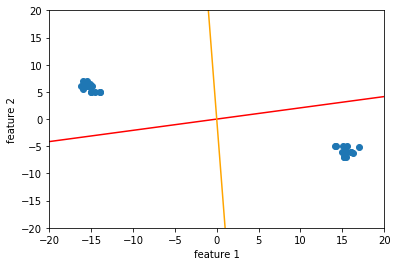

In [0]:
x_s1 = list(range(-20, 25, 5))
y_s1 = []
y_s2 = []
for el in x_s1:
  y_s1.append((-model.fc1.weight[0][0].item()/ model.fc1.weight[0][1].item()) * el)

for el in x_s1:
  y_s2.append((-model.fc2.weight[0][0].item()/ model.fc2.weight[0][1].item()) * el)

plt.plot(x_s1, y_s1, color = 'red') 
plt.plot(x_s1, y_s2, color = 'orange') 

plt.scatter(data_['X1'], data_['X2'])
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

(-0.2, 0.2)

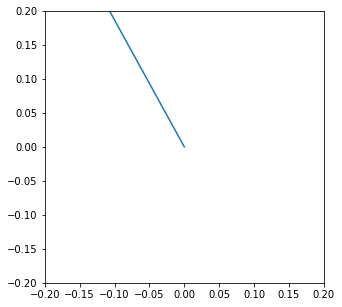

In [0]:
# xx1_l2 = [0, model.fc1.weight[0][0].item()]
# yy1_l2 = [0, model.fc1.weight[0][1].item()]
xx1 = [0, model.fc1.weight[0][0].item()]
yy1 = [0, model.fc1.weight[0][1].item()]
# xx2 = [0,model.fc2.weight[0][0].item()]
# yy2 = [0, model.fc2.weight[0][1].item()]
# xx3 = [0, model.fc3.weight[0][0].item()]
# yy3 = [0, model.fc3.weight[0][1].item()]
plt.figure(figsize = (5, 5))
# plt.plot(xx1_l2, yy1_l2, label = 'L2 regularization')
# plt.plot(xx1, yy1, label = 'L1 regularization')
# plt.legend()
plt.plot(xx1, yy1)
# plt.plot(xx3, yy3)

plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)

In [0]:
sl(model.fc1.weight, model.fc2.weight)

tensor([[0.0003]], grad_fn=<PowBackward0>)

In [0]:
model.fc1.weight[0][1]

tensor(0.8971, grad_fn=<SelectBackward>)

In [0]:
model.fc1.weight

Parameter containing:
tensor([[-0.0264,  0.0022]], requires_grad=True)

In [0]:
model.fc2.weight

Parameter containing:
tensor([[-0.0299,  0.0007]], requires_grad=True)

In [0]:
for i in model.fc1.weight[0]:
  print(torch.abs(i))

tensor(0.9038, grad_fn=<AbsBackward>)
tensor(1.2557, grad_fn=<AbsBackward>)


In [0]:
torch.sum(torch.abs(model.fc1.weight))

tensor(2.1595, grad_fn=<SumBackward0>)

In [0]:
torch.sum(torch.abs(model.fc1.weight))

tensor(1.3095, grad_fn=<SumBackward0>)